In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np
from torch.utils.data import random_split
import torch.optim as optim
import torchvision

1. Download the CIFAR-10 dataset and preprocess it. Here, you can find an example of how to do so using 
PyTorch.  Keep  in  mind  that  the  transformation in  the  example  is  just  for  demonstration  purposes.  You 
should add more transformations as part of the preprocessing step such as normalization. 

In [ ]:
#normalization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#Getting the dataset
train_dataset = CIFAR10(root='cifar10/', download=True, transform=transform)
test_dataset = CIFAR10(root='cifar10/', train=False, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting cifar10/cifar-10-python.tar.gz to cifar10/


2. Find the size of the train and test datasets. Then, find the shape of the images. Finally, print the different 
classes of the dataset. 

In [ ]:
classes = train_dataset.classes

print("Size train dataset", len(train_dataset))

print("Size test dataset", len(test_dataset))

print("shape of the images", train_dataset.data[0].shape)

print("different classes of the dataset", classes)

Size train dataset 50000
Size test dataset 10000
shape of the images (32, 32, 3)
different classes of the dataset ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


3. Visualize 2 or 3 random images and their class labels from the training and testing datasets, respectively. 

In [ ]:
def show_image(dataset, image):
  image, label = dataset[image]
  plt.imshow(image.permute((1, 2, 0)))
  print('Label:', classes[label])

Label: truck


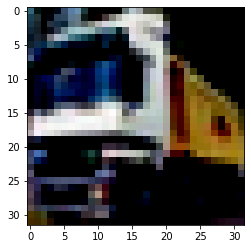

In [ ]:
#Image from train_dataset
show_image(train_dataset,1)

Label: ship


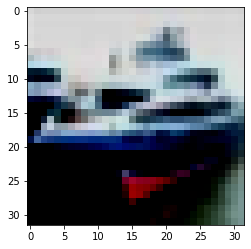

In [ ]:
#Image from test_dataset
show_image(test_dataset,1)

4. Split the training dataset into training and validation sets.

In [ ]:
#Using train and Val - 80% and 20 %
train_set_size = int(len(train_dataset) * 0.8)
val_set_size = len(train_dataset) - train_set_size 

train_dataset, val_dataset = random_split(train_dataset, [train_set_size, val_set_size])

5. Use data loaders for the three datasets

In [ ]:
batch_size=4
train_dataset_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataset_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataset_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

6667

6. Implement your convolutional neural network class to classify CIFAR-10 data using nn.Module. 

In [ ]:
#CNN
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
            #Feature learning
            #Layer 1
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4, 4),

            #Layer 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #output 64 x 4 x4

            #Classification
            nn.Flatten(), 
            nn.Linear(64*4*4, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10))
  def forward(self, x):
    return self.network(x)


7. When you are ready to train the network (refer to the Appendix in page 3), change the runtime type to 
a  GPU  to  speed  up  the  training.  (Tip:  start  with  2  epochs  to  make  sure  everything  works  before  you 

In [ ]:
# Initialize model
model = CNN()
#save the model
torch.save(model.state_dict(), 'cifar10-cnn.pth')
#Make use of cuda gpu if available and if not use cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#sending the model to cuda device
model = model.to(device)
#Optimizer and loss function
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
# Initialize optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#Function to test the dataset 
def train(epochs, dataset):
  loss_values =[]
  for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(dataset, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      # zero the parameter gradients
      optimizer.zero_grad()
      # forward + backward + optimize
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss =+ loss.item()
      #to append to loss_values only every 200 mini-batches to keep the graf clean later when doing plot
      if i % 200 == 199:
        loss_values.append(running_loss)
  return loss_values

- plot the training  and validation losses with respect to the epoch 
numbers

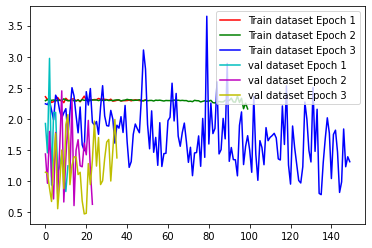

In [ ]:
plt.plot(train(epochs = 1, dataset=train_dataset_loader), color='r', label='Train dataset Epoch 1')
plt.plot(train(epochs = 2, dataset=train_dataset_loader), color='g', label='Train dataset Epoch 2')
plt.plot(train(epochs = 3, dataset=train_dataset_loader), color='b', label='Train dataset Epoch 3')

plt.plot(train(epochs = 1, dataset=val_dataset_loader), color='c', label='val dataset Epoch 1')
plt.plot(train(epochs = 2, dataset=val_dataset_loader), color='m', label='val dataset Epoch 2')
plt.plot(train(epochs = 3, dataset=val_dataset_loader), color='y', label='val dataset Epoch 3')

plt.legend()
plt.show()

8. Test your CNN using the test data. Report the accuracy of your CNN classification overall and per-class. 

In [ ]:
#Accuracy of CNN classification overall using the test data
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataset_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test input: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test input: 48 %


In [ ]:
#Accuracy of CNN classification per-class using the test data
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_dataset_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 54 %
Accuracy of automobile : 66 %
Accuracy of  bird : 12 %
Accuracy of   cat : 22 %
Accuracy of  deer : 38 %
Accuracy of   dog : 43 %
Accuracy of  frog : 59 %
Accuracy of horse : 70 %
Accuracy of  ship : 52 %
Accuracy of truck : 63 %


9. Make a new CNN class that is a copy of your original CNN. Then add a convolutional layer to the new 
network  architecture.  Train  the  new  network,  the  same  way  you  did  with  the  first  network  (same 
hyperparameters, optimizer and number of epochs ...) and compare the accuracy results (overall and per-
class) with the old network. 

In [ ]:
class New_CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
            #Feature learning
            #Layer 1
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 16
            #Layer 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #8
            #layer 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #4

            #Classification
            nn.Flatten(), 
            nn.Linear(128*4*4, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10))
  def forward(self, x):
    return self.network(x)

In [ ]:
# Initialize the new model
new_model = New_CNN()
torch.save(new_model.state_dict(), 'cifar10-cnn_new.pth')
new_model = model.to(device)
#Function to test the dataset 
def new_train(epochs, dataset):
  loss_values =[]
  for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(dataset, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      # zero the parameter gradients
      optimizer.zero_grad()
      # forward + backward + optimize
      outputs = new_model(inputs)

      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()
      running_loss =+ loss.item()
      #to append to loss_values only every 200 mini-batches to keep the graf clean later when doing plot
      if i % 200 == 199:
        loss_values.append(running_loss)
  return loss_values

- plot the training  and validation losses with respect to the epoch 
numbers

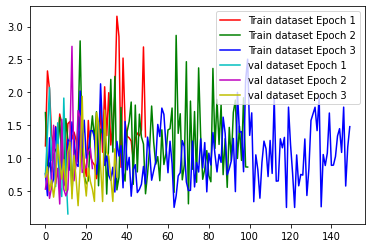

In [ ]:
plt.plot(new_train(epochs = 1, dataset=train_dataset_loader), color='r', label='Train dataset Epoch 1')
plt.plot(new_train(epochs = 2, dataset=train_dataset_loader), color='g', label='Train dataset Epoch 2')
plt.plot(new_train(epochs = 3, dataset=train_dataset_loader), color='b', label='Train dataset Epoch 3')

plt.plot(new_train(epochs = 1, dataset=val_dataset_loader), color='c', label='val dataset Epoch 1')
plt.plot(new_train(epochs = 2, dataset=val_dataset_loader), color='m', label='val dataset Epoch 2')
plt.plot(new_train(epochs = 3, dataset=val_dataset_loader), color='y', label='val dataset Epoch 3')

plt.legend()
plt.show()

In [ ]:
#check the performs of the train dataset using the test data
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataset_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = new_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test input: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test input: 64 %


In [ ]:
# Test classes and how well it performe individually using the test data

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_dataset_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = new_model(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 75 %
Accuracy of automobile : 85 %
Accuracy of  bird : 50 %
Accuracy of   cat : 56 %
Accuracy of  deer : 52 %
Accuracy of   dog : 41 %
Accuracy of  frog : 51 %
Accuracy of horse : 75 %
Accuracy of  ship : 80 %
Accuracy of truck : 72 %


- When looking at the loss graf for the 2 models - see that the first model have higher loss rate then the second model with extra layer. 
- When it comes to accuracy overall and per- class, we see second model do better then first model. 
- It looks that the the extra layer give better performance - as we see in model 2, it get 16% more then first model with only 2 layers. Having only 2 layers its not good practic but for me that help understand more, more importend in many cases add more layers wont gurantee better resulat.